In [1]:
import json
import numpy as np
import os
import cv2
import random
import pickle
from tqdm import tqdm
from enum import Enum

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from keras.models import Sequential, load_model
from keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, \
    Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.optimizers import Adam

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

Alphanum = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
            'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j',
            'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't',
            'u', 'v', 'w', 'x', 'y', 'z']


In [2]:
IMAGE_SIZE = 96
img_path = r'..\..\ImageGenerator\Targets'
json_path = r'..\..\ImageGenerator\Target Data'

In [3]:
EPOCHS = 8
INIT_LR = 1e-3
BS = 32
IMAGE_DIMS = (96, 96, 1)

data = []
labels = []
lb = LabelBinarizer()

In [4]:
def create_training_data(image_path, json_path, img_size):
    global data
    global labels
    
    training_data = []
    training_labels = []
    
    
    for img in tqdm(os.listdir(image_path)):
        image = cv2.imread(os.path.join(image_path, img))
        image = cv2.resize(image, (img_size, img_size))
        
        # try with cv.Canny()
        image = cv2.Canny(image, 100, 200)
        image = img_to_array(image)
        training_data.append(image)
        
        json_file = img[0:-4] + '.json'
        
        json_dict = json.load(open(os.path.join(json_path, json_file)))
        class_number = Alphanum.index(json_dict["alphanumeric"])
        training_labels.append(class_number)
        
        
    data = np.array(training_data, dtype="float") / 255.0
    labels = np.array(training_labels)
    
    print("[INFO] data matrix: {:.2f}MB".format(data.nbytes / (1024 * 1000.0)))
    
    labels = lb.fit_transform(labels)

In [25]:
def create_model(width, height, depth, classes):
    model = Sequential()
    input_shape = (height, width, depth)
    chan_dim = -1
    if K.image_data_format == "channels_first":
        chan_dim = 1
        
    model.add(Conv2D(32, (3, 3), padding="same", input_shape=input_shape))
    model.add(Activation("relu"))
#     model.add(BatchNormalization(axis=chan_dim))
#     model.add(Dropout(0.25))

    model.add(Conv2D(512, (3, 3), padding="same"))
    model.add(Activation("relu"))
#     model.add(BatchNormalization(axis=chan_dim))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
#     model.add(BatchNormalization(axis=chan_dim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
#     model.add(BatchNormalization(axis=chan_dim))
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
#     model.add(BatchNormalization(axis=chan_dim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
#     model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.summary()
    model.add(Activation("softmax"))
    
    return model

In [26]:
def model_training_data():
    (xTrain, xTest, yTrain, yTest) = train_test_split(data, labels, test_size=0.2, random_state=27)
    
    aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1, height_shift_range=0.1, \
                             shear_range=0.2, zoom_range=0.2, fill_mode="nearest")
    
    model = create_model(96,96,1, len(lb.classes_))
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    
    print("TRAINING NETWORK...")
    model.fit(xTrain, yTrain, validation_data=(xTest, yTest), steps_per_epoch=len(xTrain) // BS, \
              epochs=EPOCHS, verbose=1)
    
    print("SAVING MODEL...")
    model.save('alphanum_classifier.model', save_format="h5")
    f = open(r"../training_data/alphanum.pickle", "wb")
    f.write(pickle.dumps(lb))
    f.close()

In [27]:
def test_model(imagePath):
    image = cv2.imread(imagePath)
    
    image = cv2.resize(image, (96, 96))
    iamge = cv2.Canny(image, 100, 200)
    image = image.astype("float") /  255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    print(image.shape)
    lb = pickle.loads(open('../training_data/alphanum.pickle', 'rb').read())
    
    print("Classifying Image...")
    prediction = model.predict(image)[0]
    idx = np.argmax(prediction)
    label = lb.classes_[idx]
    
    print("RESULT: ", end=' ')
    print(Alphanum[idx])

In [28]:
create_training_data(img_path, json_path, 96)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 507.61it/s]


[INFO] data matrix: 72.00MB


In [ ]:
model_training_data()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 96, 96, 32)        320       
_________________________________________________________________
activation_21 (Activation)   (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 96, 96, 512)       147968    
_________________________________________________________________
activation_22 (Activation)   (None, 96, 96, 512)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 96, 96, 64)        294976    
_________________________________________________________________
activation_23 (Activation)   (None, 96, 96, 64)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 48, 48, 64)       

In [ ]:
print('check')

In [ ]:
print(labels[2])
print(data.shape)
import matplotlib.pyplot as plt
plt.imshow(data[2], cmap=plt.cm.binary)

In [ ]:
test_model('../../ImageGenerator/Targets/500.png')
plt.imshow(cv2.imread('../../ImageGenerator/Targets/.png'), cmap=plt.cm.binary)

In [ ]:
model = load_model('alphanum_classifier.model')
lb = pickle.loads(open('../training_data/alphanum.pickle', 'rb').read())

In [ ]:
imagePath = '../../ImageGenerator/Targets/100.png'

image = cv2.imread(imagePath)
image = cv2.resize(image, (96, 96))
old_image = image

# try with cv.Canny()
image = cv2.Canny(image, 100, 200)
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
print(image.shape)

print("Classifying Image...")
prediction = model.predict(image)[0]
idx = np.argmax(prediction)
label = lb.classes_[idx]

print("RESULT: ", end=' ')
print(Alphanum[idx])
plt.imshow(old_image)

In [ ]:
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [ ]:
print(len(data))

In [ ]:
print(len(labels))

In [ ]:
print(data[0].shape)

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


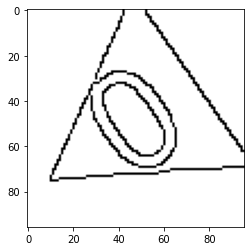

In [18]:
import matplotlib.pyplot as plt
plt.imshow(data[298], cmap=plt.cm.binary)
print(labels[298])

In [19]:
print(data[298])

[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]
